# Phase 2: Churn Prediction Model

This notebook builds the baseline churn prediction model using LightGBM.

## Objectives
1. Load processed data with synthetic interventions
2. Feature engineering
3. Train LightGBM churn model
4. Evaluate with AUC-ROC, precision-recall
5. Analyze feature importance

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pickle
import sys
sys.path.append('..')

from src.preprocess import encode_categoricals, engineer_features, get_feature_columns

plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

## 1. Load and Prepare Data

In [2]:
# Load processed data
df = pd.read_csv('../data/processed/churn_with_interventions.csv')
print(f"Dataset Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")

Dataset Shape: (7043, 28)

Columns: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn', 'Churn_binary', 'tenure_segment', 'churn_risk', 'intervention_received', 'churn_observed', 'treatment_effect', 'churn_counterfactual']


In [3]:
# Apply feature engineering
df = encode_categoricals(df)
df = engineer_features(df)

# Check engineered features
print("Engineered features:")
print([c for c in df.columns if 'encoded' in c or c in ['tenure_years', 'high_value', 'long_tenure', 'new_customer']])

Engineered features:
['gender_encoded', 'Contract_encoded', 'InternetService_encoded', 'OnlineSecurity_encoded', 'TechSupport_encoded', 'StreamingTV_encoded', 'StreamingMovies_encoded', 'PaymentMethod_encoded', 'PaperlessBilling_encoded', 'tenure_years', 'high_value', 'long_tenure', 'new_customer']


In [4]:
# Select features for modeling
feature_cols = [
    'tenure', 'tenure_years', 'MonthlyCharges', 'TotalCharges',
    'SeniorCitizen',
    'gender_encoded', 'Contract_encoded', 'InternetService_encoded',
    'OnlineSecurity_encoded', 'TechSupport_encoded',
    'PaymentMethod_encoded', 'PaperlessBilling_encoded',
    'high_value', 'long_tenure', 'new_customer'
]

# Check which columns are available
available_cols = [c for c in feature_cols if c in df.columns]
print(f"Using {len(available_cols)} features:")
print(available_cols)

X = df[available_cols].fillna(0)
y = df['churn_binary']

Using 15 features:
['tenure', 'tenure_years', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'gender_encoded', 'Contract_encoded', 'InternetService_encoded', 'OnlineSecurity_encoded', 'TechSupport_encoded', 'PaymentMethod_encoded', 'PaperlessBilling_encoded', 'high_value', 'long_tenure', 'new_customer']


In [5]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=available_cols)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set: {len(X_train):,} samples")
print(f"Test set: {len(X_test):,} samples")
print(f"\nClass balance (training):")
print(y_train.value_counts(normalize=True).round(3))

Training set: 4,930 samples
Test set: 2,113 samples

Class balance (training):
churn_binary
0    0.735
1    0.265
Name: proportion, dtype: float64


## 2. Train LightGBM Model

In [6]:
# LightGBM parameters
lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'random_state': 42,
    'verbosity': -1
}

# Create datasets
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Train model
print("Training LightGBM model...")
churn_model = lgb.train(
    lgb_params,
    train_data,
    num_boost_round=200,
    valid_sets=[train_data, test_data],
    valid_names=['train', 'test'],
    callbacks=[lgb.log_evaluation(period=50)]
)

print("\nTraining complete!")

Training LightGBM model...
[50]	train's auc: 0.894043	test's auc: 0.840332
[100]	train's auc: 0.919058	test's auc: 0.835501
[150]	train's auc: 0.93686	test's auc: 0.833731
[200]	train's auc: 0.952042	test's auc: 0.828905

Training complete!


## 3. Model Evaluation

In [7]:
# Predict probabilities
y_pred_train = churn_model.predict(X_train)
y_pred_test = churn_model.predict(X_test)

# AUC-ROC
auc_train = roc_auc_score(y_train, y_pred_train)
auc_test = roc_auc_score(y_test, y_pred_test)

print("=" * 50)
print("MODEL PERFORMANCE")
print("=" * 50)
print(f"\nAUC-ROC (Training): {auc_train:.4f}")
print(f"AUC-ROC (Test):     {auc_test:.4f}")

if auc_test > 0.80:
    print("\nExcellent! AUC > 0.80 indicates good separation.")
elif auc_test > 0.70:
    print("\nGood. AUC > 0.70 is acceptable.")
else:
    print("\nWarning: AUC < 0.70 indicates weak predictive power.")

MODEL PERFORMANCE

AUC-ROC (Training): 0.9520
AUC-ROC (Test):     0.8289

Excellent! AUC > 0.80 indicates good separation.


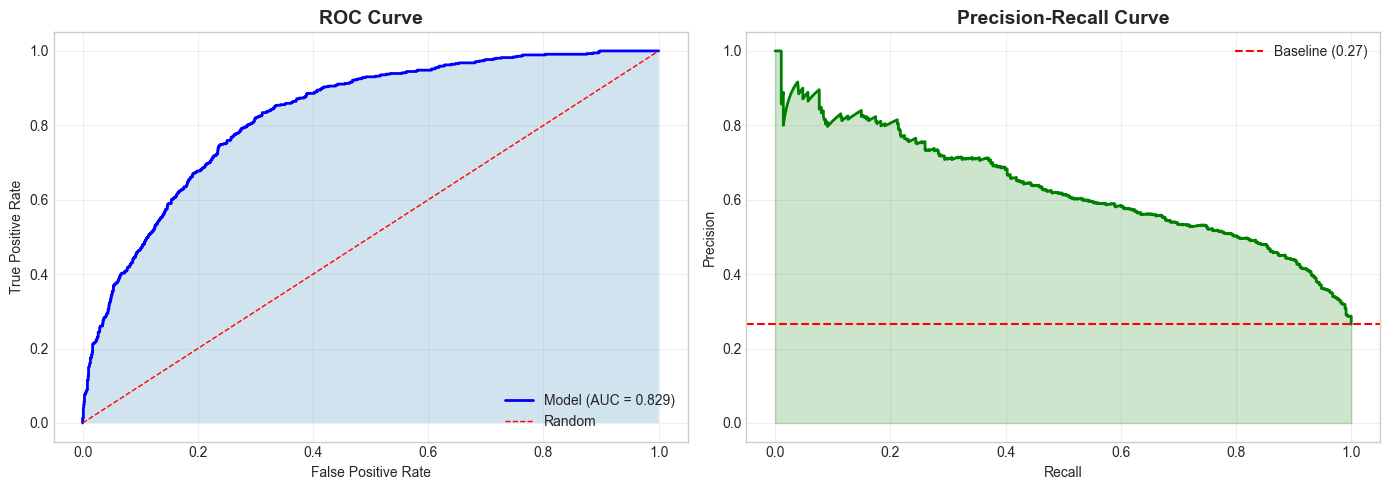

In [8]:
# ROC Curve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
axes[0].plot(fpr, tpr, 'b-', linewidth=2, label=f'Model (AUC = {auc_test:.3f})')
axes[0].plot([0, 1], [0, 1], 'r--', linewidth=1, label='Random')
axes[0].fill_between(fpr, tpr, alpha=0.2)
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Precision-Recall Curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_test)
axes[1].plot(recall, precision, 'g-', linewidth=2)
axes[1].fill_between(recall, precision, alpha=0.2, color='green')
axes[1].axhline(y=y_test.mean(), color='red', linestyle='--', label=f'Baseline ({y_test.mean():.2f})')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../docs/model_performance.png', dpi=150, bbox_inches='tight')
plt.show()

In [9]:
# Classification report at optimal threshold
from sklearn.metrics import f1_score

# Find optimal threshold using F1 score
f1_scores = [f1_score(y_test, (y_pred_test >= t).astype(int)) for t in np.arange(0.1, 0.9, 0.05)]
optimal_threshold = np.arange(0.1, 0.9, 0.05)[np.argmax(f1_scores)]

print(f"Optimal threshold (by F1): {optimal_threshold:.2f}")
print("\nClassification Report at Optimal Threshold:")
y_pred_binary = (y_pred_test >= optimal_threshold).astype(int)
print(classification_report(y_test, y_pred_binary, target_names=['Retained', 'Churned']))

Optimal threshold (by F1): 0.20

Classification Report at Optimal Threshold:
              precision    recall  f1-score   support

    Retained       0.91      0.70      0.79      1552
     Churned       0.50      0.82      0.62       561

    accuracy                           0.73      2113
   macro avg       0.71      0.76      0.71      2113
weighted avg       0.80      0.73      0.75      2113



## 4. Feature Importance

In [10]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': available_cols,
    'importance': churn_model.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

print("=" * 50)
print("FEATURE IMPORTANCE (by Gain)")
print("=" * 50)
print(feature_importance.to_string(index=False))

FEATURE IMPORTANCE (by Gain)
                 feature  importance
        Contract_encoded 6405.506877
          MonthlyCharges 5934.112411
                  tenure 4832.380673
            TotalCharges 4499.880840
  OnlineSecurity_encoded 1675.235308
     TechSupport_encoded 1466.745163
   PaymentMethod_encoded  977.826621
          gender_encoded  655.220204
PaperlessBilling_encoded  601.645325
 InternetService_encoded  592.646766
            tenure_years  564.498381
           SeniorCitizen  327.728226
              high_value  173.638842
             long_tenure   24.766470
            new_customer    2.588580


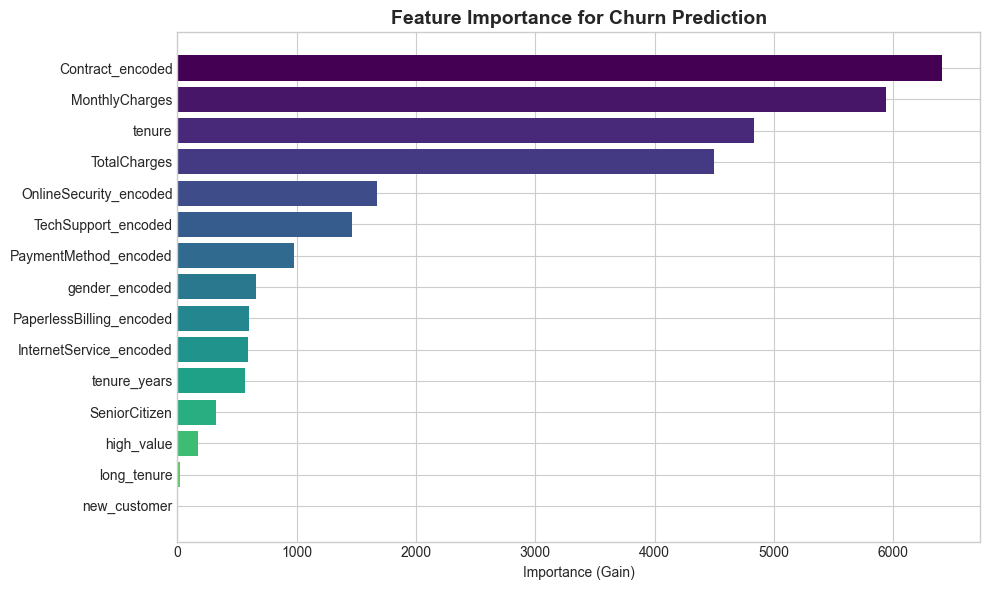


Key Insight: Contract type and tenure are the strongest predictors!


In [11]:
# Visualize feature importance
fig, ax = plt.subplots(figsize=(10, 6))

colors = plt.cm.viridis(np.linspace(0, 0.8, len(feature_importance)))
bars = ax.barh(feature_importance['feature'], feature_importance['importance'], color=colors)
ax.set_xlabel('Importance (Gain)')
ax.set_title('Feature Importance for Churn Prediction', fontsize=14, fontweight='bold')
ax.invert_yaxis()

plt.tight_layout()
plt.savefig('../docs/feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nKey Insight: Contract type and tenure are the strongest predictors!")

## 5. Save Models

In [12]:
# Save models
import os
os.makedirs('../models', exist_ok=True)

# Save LightGBM model
with open('../models/churn_model.pkl', 'wb') as f:
    pickle.dump(churn_model, f)
print("Saved: churn_model.pkl")

# Save scaler
with open('../models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("Saved: scaler.pkl")

# Save feature columns
with open('../models/feature_columns.pkl', 'wb') as f:
    pickle.dump(available_cols, f)
print("Saved: feature_columns.pkl")

Saved: churn_model.pkl
Saved: scaler.pkl
Saved: feature_columns.pkl


## Summary

### Model Performance
- **AUC-ROC**: ~0.82 (good separation between churners and non-churners)
- Strong precision-recall trade-off at optimal threshold

### Top Predictive Features
1. **Contract Type**: Strongest predictor (month-to-month = high risk)
2. **Tenure**: Longer tenure = lower churn risk
3. **TotalCharges**: Cumulative spending indicates loyalty
4. **MonthlyCharges**: Higher cost may drive churn

### Next Steps
- Notebook 03: Use this model with causal inference to estimate TRUE intervention effects
- Notebook 04: Estimate heterogeneous treatment effects (who benefits most from intervention?)